# Purpose

This one demos output for `v0.3.2` that includes top subreddits (no Geo) AND German-relevant subreddits! Should be helpful to check for subreddit counterparts.

Use this notebook to present the outputs for the final output (or close to it). 

We need this notebook to show some clear examples on how to use the data and where/how we can use it.

# Imports & Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import logging
from pprint import pprint

import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import seaborn as sns

import mlflow

import omegaconf
from omegaconf import OmegaConf
from subclu.utils.hydra_config_loader import LoadHydraConfig

import subclu
from subclu.data.data_loaders import LoadSubreddits, LoadPosts
from subclu.utils import set_working_directory
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)
from subclu.utils.language_code_mapping import (
    L_CLD3_CODES_FOR_LANGUAGES_IN_USE_MULTILINGUAL,
    D_CLD3_CODE_TO_LANGUAGE_NAME,
)
from subclu.utils.mlflow_logger import MlflowLogger
from subclu.eda.aggregates import compare_raw_v_weighted_language
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl
)

# ---
from tqdm.auto import tqdm

print_lib_versions([np, pd, plotly, sns, subclu])

python		v 3.7.10
===
numpy		v: 1.19.5
pandas		v: 1.2.4
plotly		v: 4.14.3
seaborn		v: 0.11.1
subclu		v: 0.3.2


In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Set sqlite database as MLflow URI

In [4]:
# use new class to initialize mlflow
mlf = MlflowLogger(tracking_uri='sqlite')
mlflow.get_tracking_uri()

'sqlite:////home/jupyter/subreddit_clustering_i18n/mlflow_sync/djb-100-2021-04-28-djb-eda-german-subs/mlruns.db'

## Get list of experiments with new function

In [5]:
mlf.list_experiment_meta(output_format='pandas').tail(8)

,experiment_id,name,artifact_location,lifecycle_stage
5,5,use_multilingual_v0.1_test,gs://i18n-subreddit-clustering/mlflow/mlruns/5,active
6,6,use_multilingual_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/6,active
7,7,use_multilingual_v1_aggregates_test,gs://i18n-subreddit-clustering/mlflow/mlruns/7,active
8,8,use_multilingual_v1_aggregates,gs://i18n-subreddit-clustering/mlflow/mlruns/8,active
9,9,v0.3.2_use_multi_inference_test,gs://i18n-subreddit-clustering/mlflow/mlruns/9,active
10,10,v0.3.2_use_multi_inference,gs://i18n-subreddit-clustering/mlflow/mlruns/10,active
11,11,v0.3.2_use_multi_aggregates_test,gs://i18n-subreddit-clustering/mlflow/mlruns/11,active
12,12,v0.3.2_use_multi_aggregates,gs://i18n-subreddit-clustering/mlflow/mlruns/12,active


# Load config
Use Hydra configs to make it easier to replicate the run.

Copy the config to the model folder so it's easier to trace it back

In [6]:
mlflow_experiment_test = 'v0.3.2_use_multi_aggregates_test'
# mlflow_experiment_full = 'v0.3.2_use_multi_aggregates'

config_full_lc_false = LoadHydraConfig(
    config_name='clustering_adhoc',
    config_path="../config",
    overrides=[f"data_text_and_metadata=top_subreddits_2021_07_16",
               'data_embeddings_to_cluster=top_subs-2021_07_16-use_multi_lower_case_false_00',
              ]
)

# pprint(config_test_sample_lc_false.config_dict, indent=2)

In [7]:
pprint(config_full_lc_false.config_dict)

{'data_embeddings_to_cluster': {'df_post_level_agg_b_post_and_comments': 'df_post_level_agg_b_post_and_comments',
                                'df_post_level_agg_c_post_comments_sub_desc': 'df_post_level_agg_c_post_comments_sub_desc',
                                'df_sub_level_agg_a_post_only': 'df_sub_level_agg_a_post_only',
                                'df_sub_level_agg_a_post_only_similarity': 'df_sub_level_agg_a_post_only_similarity',
                                'df_sub_level_agg_a_post_only_similarity_pair': 'df_sub_level_agg_a_post_only_similarity_pair',
                                'df_sub_level_agg_b_post_and_comments': 'df_sub_level_agg_b_post_and_comments',
                                'df_sub_level_agg_b_post_and_comments_similarity': 'df_sub_level_agg_b_post_and_comments_similarity',
                                'df_sub_level_agg_b_post_and_comments_similarity_pair': 'df_sub_level_agg_b_post_and_comments_similarity_pair',
                              

In [8]:
d_embeddings = config_full_lc_false.config_dict['data_embeddings_to_cluster']
d_conf_meta = config_full_lc_false.config_dict['data_text_and_metadata']

run_uuid = d_embeddings['run_uuid']

f_embeddings_sub_level = d_embeddings['df_sub_level_agg_c_post_comments_and_sub_desc']
f_embeddings_post_level = d_embeddings['df_post_level_agg_c_post_comments_sub_desc']

f_sub_distance_c = d_embeddings['df_sub_level_agg_c_post_comments_and_sub_desc_similarity']
f_sub_dist_pair = d_embeddings['df_sub_level_agg_c_post_comments_and_sub_desc_similarity_pair']


l_ix_sub = d_embeddings['l_ix_sub']  # 'subreddit_id',  b/c of dask's multi-index, I'm only using nam
l_ix_post = d_embeddings['l_ix_post']

# List & load artifacts from selected run

This is a run-ID for a process that outputs post-level and subreddit artifacts (after aggregation).

In [9]:
# %%time

# d_dfs_mlflow = mlf.read_run_artifact(
#     run_id=run_uuid,
#     artifact_folder='d_logged_dfs_subfolders/d_logged_dfs_subfolders.json',
#     read_function='json',
# )

# pprint(list(d_dfs_mlflow.keys()))

## Load distances

In [10]:
%%time

df_sub_d_pair_raw = mlf.read_run_artifact(
    run_id=run_uuid,
    artifact_folder=f_sub_dist_pair,
    read_function='pd_parquet',
)
try:
    df_sub_d_pair_raw = df_sub_d_pair_raw.drop(['index'], axis=1)
except KeyError:
    pass

print(df_sub_d_pair_raw.shape)

18:59:46 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/12/99158c385c5442b1bf5ff96fc44af7da/artifacts/df_sub_level_agg_c_post_comments_and_sub_desc_similarity_pair"


  0%|          | 0/36 [00:00<?, ?it/s]

18:59:46 | INFO | "  Parquet files found: 34"


(14186522, 3)
CPU times: user 3.56 s, sys: 707 ms, total: 4.26 s
Wall time: 2 s


In [11]:
df_sub_d_pair_raw.head()

,cosine_distance,subreddit_name_a,subreddit_name_b
0,0.719657,1071,tamamahbapengelli
1,0.708699,1071,nonakanal
2,0.706756,1071,okemakkermaloot
3,0.706363,1071,kudurdum
4,0.698231,1071,okbrudimongo


## Load post metadata - explore language labels

Now that we're moving beyond German, we want to know what's the predominant language in a subreddit

In [12]:
# print(len(L_CLD3_CODES_FOR_LANGUAGES_IN_USE_MULTILINGUAL))
# for code_ in L_CLD3_CODES_FOR_LANGUAGES_IN_USE_MULTILINGUAL:
#     print(f"{code_}: {D_CLD3_CODE_TO_LANGUAGE_NAME[code_]}")

In [13]:
pprint(d_conf_meta)

{'bucket_name': 'i18n-subreddit-clustering',
 'dataset_name': 'Top Subreddits (no Geo) + German Subs 2021-07-16, comments: '
                 '2021-07-09',
 'folder_comments_text_and_meta': 'comments/top/2021-07-09',
 'folder_posts_text_and_meta': 'posts/top/2021-07-16',
 'folder_subreddits_text_and_meta': 'subreddits/top/2021-07-16'}


In [14]:
%%time
l_cols_post_aggs_only = [
    'subreddit_name',
    'subreddit_id',
    'post_id',
    'weighted_language',    # For language aggs
    'post_type',            # For post aggs
    'combined_topic_and_rating',    # Needed for new manual label
    'text_word_count',      # To get median post word count
]

df_post_meta = LoadPosts(
    bucket_name=d_conf_meta['bucket_name'],
    folder_path=d_conf_meta['folder_posts_text_and_meta'],
    columns=l_cols_post_aggs_only,
).read_and_apply_transformations()

18:59:48 | INFO | "Reading raw data..."
18:59:48 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/posts/top/2021-07-16"


  0%|          | 0/43 [00:00<?, ?it/s]

18:59:49 | INFO | "  Applying transformations..."


CPU times: user 9.16 s, sys: 419 ms, total: 9.58 s
Wall time: 9.04 s


In [64]:
counts_describe(df_post_meta)

,dtype,count,unique,unique-percent,null-count,null-percent
subreddit_name,object,"1,649,929","3,767",0.23%,0,0.00%
subreddit_id,object,"1,649,929","3,767",0.23%,0,0.00%
post_id,object,"1,649,929","1,649,929",100.00%,0,0.00%
weighted_language,object,"1,649,929",109,0.01%,0,0.00%
post_type,object,"1,649,929",10,0.00%,0,0.00%
combined_topic_and_rating,object,"1,649,929",51,0.00%,0,0.00%
text_word_count,int64,"1,649,929","3,135",0.19%,0,0.00%
weighted_language_top,object,"1,649,929",36,0.00%,0,0.00%
weighted_language_in_use_multilingual,bool,"1,649,929",2,0.00%,0,0.00%
post_type_agg3,object,"1,649,929",4,0.00%,0,0.00%


In [16]:
value_counts_and_pcts(
    df_post_meta['weighted_language_top'],
    top_n=20,
)

,weighted_language_top-count,weighted_language_top-percent,weighted_language_top-pct_cumulative_sum
English,"1,370,419",83.1%,83.1%
German,"75,712",4.6%,87.6%
Other language,"33,906",2.1%,89.7%
Portuguese,"13,887",0.8%,90.5%
Spanish,"13,788",0.8%,91.4%
UNKNOWN,"9,172",0.6%,91.9%
French,"9,102",0.6%,92.5%
Norwegian,"8,836",0.5%,93.0%
Afrikaans,"8,737",0.5%,93.6%
Dutch,"8,077",0.5%,94.0%


In [17]:
%%time

df_post_meta['weighted_language_name'] = df_post_meta['weighted_language'].replace(D_CLD3_CODE_TO_LANGUAGE_NAME)

CPU times: user 5.45 s, sys: 78.2 ms, total: 5.53 s
Wall time: 5.53 s


In [18]:
# list(df_post_meta['weighted_language'].value_counts().head(30).index)

In [19]:
# set(df_post_meta['weighted_language'].value_counts().head(30).index) - set(L_CLD3_CODES_FOR_LANGUAGES_IN_USE_MULTILINGUAL)

In [20]:
value_counts_and_pcts(
    df_post_meta,
    ['weighted_language_in_use_multilingual'],
    top_n=22,
)

,count,percent,cumulative_percent
weighted_language_in_use_multilingual,,,
True,"1,514,747",91.8%,91.8%
False,"135,182",8.2%,100.0%


In [21]:
value_counts_and_pcts(
    df_post_meta,
    ['weighted_language', 'weighted_language_name', 'weighted_language_in_use_multilingual'],
    top_n=22,
)

,,,count,percent,cumulative_percent
weighted_language,weighted_language_name,weighted_language_in_use_multilingual,,,
en,English,True,"1,370,419",83.1%,83.1%
de,German,True,"75,712",4.6%,87.6%
pt,Portuguese,True,"13,887",0.8%,88.5%
es,Spanish,True,"13,788",0.8%,89.3%
UNKNOWN,UNKNOWN,False,"9,172",0.6%,89.9%
fr,French,True,"9,102",0.6%,90.4%
no,Norwegian,False,"8,836",0.5%,91.0%
af,Afrikaans,False,"8,737",0.5%,91.5%
nl,Dutch,True,"8,077",0.5%,92.0%


## Load metadata

This run of pair distances didn't have the metadata attached... so let's attach it

In [22]:
%%time
df_sub_meta = LoadSubreddits(
    bucket_name=d_conf_meta['bucket_name'],
    folder_path=d_conf_meta['folder_subreddits_text_and_meta'],
    folder_posts=d_conf_meta['folder_posts_text_and_meta'],
    columns=None,
).read_apply_transformations_and_merge_post_aggs()

19:00:03 | INFO | "Loading df_posts from: posts/top/2021-07-16"
19:00:04 | INFO | "Reading raw data..."
19:00:04 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/posts/top/2021-07-16"


  0%|          | 0/43 [00:00<?, ?it/s]

19:00:05 | INFO | "  Applying transformations..."
19:00:12 | INFO | "  reading sub-level data & merging with aggregates..."
19:00:12 | INFO | "Reading raw data..."
19:00:12 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/subreddits/top/2021-07-16"


  0%|          | 0/1 [00:00<?, ?it/s]

19:00:13 | INFO | "  Applying transformations..."


CPU times: user 10.9 s, sys: 714 ms, total: 11.6 s
Wall time: 11 s


In [23]:
# [c for c in df_sub_meta.columns if 'lang' in c]

In [24]:
l_cols_inspect_meta = [
    'subreddit_name',
    'combined_topic_and_rating',
    'rating',
    'topic',
    'over_18',
    
    'subreddit_title',
    
    'primary_post_language',
    'primary_post_language_percent',
    'primary_post_language_in_use_multilingual',

]
l_cols_language_percent = [c for c in df_sub_meta.columns if c.endswith('_posts_percent')]

# df_sub_meta[l_cols_inspect_meta + l_cols_language_percent].head()

In [25]:
# df_sub_meta[l_cols_inspect_meta + l_cols_language_percent].tail()

In [26]:
# df_sub_meta[[c for c in df_sub_meta.columns if c.endswith('_posts_percent')]].head()

In [27]:
# pprint(list(df_sub_meta.columns))

### Merge meta with distance
see `transform_distance_data_for_bq` for function

In [28]:
%%time

col_new_manual_topic = 'manual_topic_and_rating'

l_meta_basic = [
    'subreddit_name',
    'subreddit_id',
    col_new_manual_topic,
    'rating',
    'topic',
    'primary_post_language',
    'primary_post_language_percent',
    'post_median_word_count',
]
df_sub_d_pair = (
    df_sub_d_pair_raw
    .merge(
        df_sub_meta[l_meta_basic].set_index('subreddit_name'),
        left_on=['subreddit_name_a'],
        right_index=True,
    )
    .merge(
        df_sub_meta[l_meta_basic].set_index('subreddit_name'),
        left_on=['subreddit_name_b'],
        right_index=True,
        suffixes=('_a', '_b')
    )
    .sort_values(by=['subreddit_name_a', 'cosine_distance'], ascending=[True, False])
)

CPU times: user 26.9 s, sys: 2.98 s, total: 29.9 s
Wall time: 29.9 s


In [29]:
df_sub_d_pair.head()

,cosine_distance,subreddit_name_a,subreddit_name_b,subreddit_id_a,manual_topic_and_rating_a,rating_a,topic_a,primary_post_language_a,primary_post_language_percent_a,post_median_word_count_a,subreddit_id_b,manual_topic_and_rating_b,rating_b,topic_b,primary_post_language_b,primary_post_language_percent_b,post_median_word_count_b
0,0.719657,1071,tamamahbapengelli,t5_4ppr4q,uncategorized,None,None,Turkish,0.845133,9.0,t5_pwwzi,uncategorized,None,None,Turkish,0.677419,4.0
1,0.708699,1071,nonakanal,t5_4ppr4q,uncategorized,None,None,Turkish,0.845133,9.0,t5_2ltn31,uncategorized,None,None,German,0.712589,6.0
2,0.706756,1071,okemakkermaloot,t5_4ppr4q,uncategorized,None,None,Turkish,0.845133,9.0,t5_pa6tc,uncategorized,None,None,Dutch,0.358974,3.0
3,0.706363,1071,kudurdum,t5_4ppr4q,uncategorized,None,None,Turkish,0.845133,9.0,t5_2pn1vr,uncategorized,None,None,Turkish,0.544170,7.0
4,0.698231,1071,okbrudimongo,t5_4ppr4q,uncategorized,None,None,Turkish,0.845133,9.0,t5_ofkj1,internet culture and memes,r,Internet Culture and Memes,German,0.651042,4.0


# Load clusters

Currently ad-hoc

In [30]:
path_clusters_mod = 'manual_2021-08-11_04_45'
bucket_clusters = f'gs://i18n-subreddit-clustering/data/models/clustering/{path_clusters_mod}'

f_subs_meta_and_svd = 'df_subs_meta_and_svd-3767_by_88.parquet'
f_subs_cluster_labels = 'df_subs_only-multiple_clustering_algos-3767_by_56.parquet'

col_clustering = 'cluster_id_agg_ward_cosine_200'

In [31]:
!gsutil ls -r $bucket_clusters

gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-08-11_04_45/:
gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-08-11_04_45/df_posts_meta_and_svd-1651709_by_72.parquet
gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-08-11_04_45/df_subs_meta_and_svd-3767_by_88.parquet
gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-08-11_04_45/df_subs_only-multiple_clustering_algos-3767_by_56.parquet
gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-08-11_04_45/df_svd_posts_and_subs-1655476_by_50.parquet
gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-08-11_04_45/hydra_config.yaml


In [81]:
%%time
df_subs_meta_plot_raw = pd.read_parquet(f"{bucket_clusters}/{f_subs_cluster_labels}")

df_subs_meta_plot_raw.shape

CPU times: user 150 ms, sys: 44.9 ms, total: 195 ms
Wall time: 1.01 s


(3767, 56)

## Add new columns for predominant language so we can display them

In [33]:
# [c for c in df_sub_meta.columns if 'lang' in c]

In [82]:
%%time
df_subs_meta_plot = df_subs_meta_plot_raw.merge(
    df_sub_meta[['subreddit_name', 'primary_post_language', 'primary_post_language_percent',
                 'primary_post_language_in_use_multilingual',
                ]],
    how='left',
    on=['subreddit_name']
)
df_subs_meta_plot.shape

CPU times: user 19.9 ms, sys: 390 µs, total: 20.3 ms
Wall time: 18.5 ms


(3767, 59)

In [83]:
df_subs_meta_plot.head()

,subreddit_name,cluster_id_hdbscan_euclidean,cluster_id_hdbscan_cosine,cluster_id_hdbscan_cosine_soft,cluster_id_kmeans_25,cluster_id_kmeans_50,cluster_id_kmeans_75,cluster_id_kmeans_100,cluster_id_kmeans_200,cluster_id_dbscan_euclidean,cluster_id_agg_ward_euclidean_100,cluster_id_agg_ward_cosine_100,cluster_id_agg_ward_cosine_120,cluster_id_agg_ward_cosine_200,cluster_id_agg_avg_cosine_100,cluster_id_agg_complete_cosine_100,svd_0,svd_1,svd_2,subreddit_id,combined_topic,combined_topic_and_rating,rating,rating_version,topic,topic_version,over_18,allow_top,video_whitelisted,subreddit_language,whitelist_status,subscribers,first_screenview_date,last_screenview_date,users_l7,users_l28,posts_l7,posts_l28,comments_l7,comments_l28,pt,subreddit_clean_description_word_count,subreddit_name_title_and_clean_descriptions_word_count,subreddit_title,subreddit_public_description,subreddit_description,subreddit_name_title_and_clean_descriptions,manual_topic_and_rating,German_posts_percent,English_posts_percent,other_language_posts_percent,image_post_type_percent,link_post_type_percent,other_post_type_percent,text_post_type_percent,post_median_word_count,primary_post_language,primary_post_language_percent,primary_post_language_in_use_multilingual
0,169,-1,-1,131,9,32,67,42,3,0,38,42,42,4,11,36,0.184525,0.235692,0.139772,t5_3pt6m,uncategorized,uncategorized,None,None,None,None,f,t,None,de,None,210,2020-08-24,2021-07-13,299,1102,23,53,30,76,2021-07-16,0,10,169,The Eternal Flame of 169. Bite these Onions.,None,169. \n169. \nThe Eternal Flame of 169. Bite these Onions.. \n,uncategorized,0.081081,0.418919,0.500000,0.635135,0.040541,0.243243,0.081081,2.5,English,0.418919,True
1,1through10,-1,-1,52,9,30,59,85,159,-1,71,15,15,3,64,25,0.100676,0.090631,0.226446,t5_vk9yz,uncategorized,uncategorized,pg,v2,None,None,f,t,None,en,all_ads,821,2020-08-24,2021-07-13,116,283,24,62,31,74,2021-07-16,40,95,1through10,"Guess an integer between one and ten. Then a moderator will determine the correct answer using a random number generator and comment with the correct number within 48 hours. If you guessed the number wrong, you get a one day ban. If you...","Guess a number between one and ten. Then the mod comments the correct number within 24 hours. If you guessed the number wrong, you get a one day ban. If you guess it right, you theoretically get lots of upvotes.","1through10. \n1through10. \nGuess an integer between one and ten. Then a moderator will determine the correct answer using a random number generator and comment with the correct number within 48 hours. If you guessed the number wrong, y...",uncategorized,0.000000,0.023256,0.976744,0.000000,0.000000,0.000000,1.000000,1.0,UNKNOWN,0.930233,False
2,2137,-1,-1,129,10,32,5,42,116,0,85,42,42,4,11,36,0.126028,0.191419,0.063857,t5_3jpyb,uncategorized,uncategorized,None,None,None,None,f,t,None,pl,None,5152,2020-08-24,2021-07-13,2792,7629,60,223,69,275,2021-07-16,68,73,Kremówkarz Wojtyła,"Subreddit ma na celu pielęgnowanie i kultywowanie wspaniałej tradycji satyry i humoru jaką Jan Paweł 2 nam pozostawił. Wszyscy, którzy go znali wiedzą, że to wielki człowiek z wielkim dystansem do siebie i poczuciem humoru. Niestety w K...","Subreddit ma na celu pielęgnowanie i kultywowanie wspaniałej tradycji satyry i humoru jaką Jan Paweł 2 nam pozostawił. Wszyscy, którzy go znali wiedzą, że to wielki człowiek z wielkim dystansem do siebie i poczuciem humoru. Niestety w K...","2137. \nKremówkarz Wojtyła. \nSub ma na celu pielęgnowanie i kultywowanie wspaniałej tradycji satyry i humoru jaką Jan Paweł 2 nam pozostawił. Wszyscy, którzy go znali wiedzą, że to wielki człowiek z wielkim dystansem do siebie i poczuc...",uncategorized,0.023179,0.072848,0.903974,0.791391,0.129139,0.062914,0.016556,3.0,Polish,0.658940,True
3,24fun,104,-1,125,10,32,47,49,173,0,6,30,14,89,11,50,0.175870,0.161014,0.023054,t5_zw6pb,uncategorized,uncategorized,pg13,v2,None,None,f,t,None,en,all_ads,1206,2020-08-24,2021-07-13,443,1699,222,682,3,3,2021-07-16,65,67

In [35]:
# df_subs_meta_plot.head()

In [36]:
# counts_describe(df_subs_meta_plot)

# Context - why does this work matter?
Of the 628 most active German subreddits, almost half of the top German subs are unlabeled (`uncategorized`) and 

In [37]:
col_manual_labels = 'manual_topic_and_rating'

value_counts_and_pcts(
    df_subs_meta_plot[col_manual_labels],
    add_col_prefix=False,
    reset_index=True,
    top_n=20,
)

,manual_topic_and_rating,count,percent,cumulative_percent
0,uncategorized,"2,935",77.9%,77.9%
1,over18_nsfw,359,9.5%,87.4%
2,gaming,46,1.2%,88.7%
3,internet culture and memes,40,1.1%,89.7%
4,place/culture,29,0.8%,90.5%
5,technology,29,0.8%,91.3%
6,music,21,0.6%,91.8%
7,crypto,19,0.5%,92.3%
8,animals and pets,17,0.5%,92.8%
9,podcasts and streamers,15,0.4%,93.2%


# Plot all subs

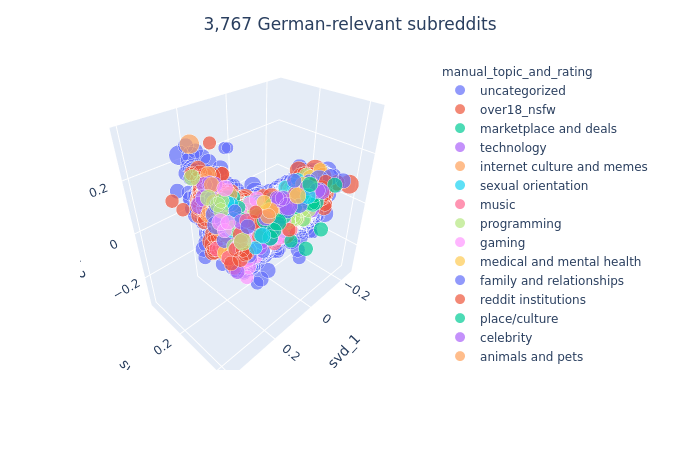

CPU times: user 492 ms, sys: 63.5 ms, total: 556 ms
Wall time: 4.29 s


In [38]:
%%time

df_plot_ = (
    df_subs_meta_plot  #[df_subs_meta_plot['subreddit_name'].isin(set_subs_all_similar)]
)

l_custom_data_subs = [
  'subreddit_name', 
  col_manual_labels,
  # 'text_1',
  # 'text_2',
]
sub_hover_data = "<br>".join([
    "subreddit name: %{customdata[0]}",
    "subreddit manual label: %{customdata[1]}",
    # "post text: %{customdata[2]}",
    # "  %{customdata[3]}"
])

fig = px.scatter_3d(
    df_plot_,
    y='svd_0', x='svd_1', z='svd_2',
    color=col_manual_labels,  # color=col_manual_labels,
    custom_data=l_custom_data_subs,
    size=np.log2(1 + df_plot_['users_l28']),
#     text='subreddit_name',
    # hoverinfo='text',
)

fig.update_traces(hovertemplate=sub_hover_data)
fig.update_layout(
    title_text=(
        # f"Most similar subreddits to <i>r/{sub_}</i>"
        f"{len(df_subs_meta_plot):,.0f} German-relevant subreddits"
        # f"<br>Clustering algo: {c_name.replace('cluster_id', '').replace('_', ' ')}"
        # f"<br>Using posts from 04-01-2021 to 05-08-2021"
    ),
    title_x=0.5,
    width=800,
    height=600,
#     uniformtext_minsize=8, uniformtext_mode='hide'
)
fig.show(renderer='png')
# fig.show()

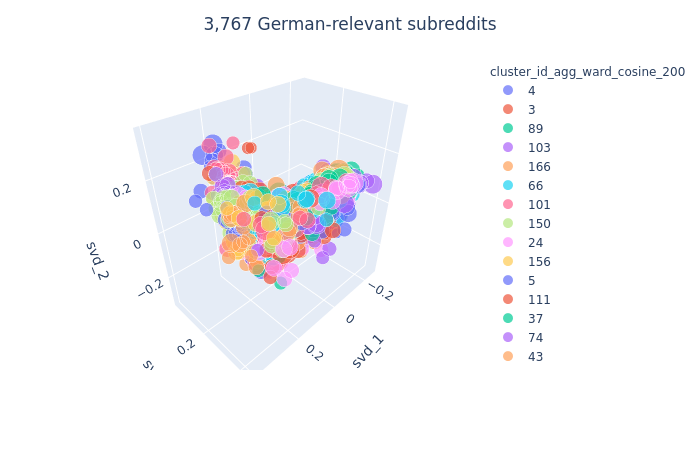

CPU times: user 1.17 s, sys: 12 ms, total: 1.18 s
Wall time: 5.59 s


In [39]:
%%time

df_plot_ = (
    df_subs_meta_plot  #[df_subs_meta_plot['subreddit_name'].isin(set_subs_all_similar)]
)

l_custom_data_subs = [
  'subreddit_name', 
  col_manual_labels,
  # 'text_1',
  # 'text_2',
]
sub_hover_data = "<br>".join([
    "subreddit name: %{customdata[0]}",
    "subreddit manual label: %{customdata[1]}",
    # "post text: %{customdata[2]}",
    # "  %{customdata[3]}"
])

fig = px.scatter_3d(
    df_plot_,
    y='svd_0', x='svd_1', z='svd_2',
    color=col_clustering,  # color=col_manual_labels,
    custom_data=l_custom_data_subs,
    size=np.log2(1 + df_plot_['users_l28']),
#     text='subreddit_name',
    # hoverinfo='text',
)

fig.update_traces(hovertemplate=sub_hover_data)
fig.update_layout(
    title_text=(
        # f"Most similar subreddits to <i>r/{sub_}</i>"
        f"{len(df_subs_meta_plot):,.0f} German-relevant subreddits"
        # f"<br>Clustering algo: {c_name.replace('cluster_id', '').replace('_', ' ')}"
        # f"<br>Using posts from 04-01-2021 to 05-08-2021"
    ),
    title_x=0.5,
    width=800,
    height=600,
#     uniformtext_minsize=8, uniformtext_mode='hide'
)
fig.show(renderer='png')
# fig.show()

## Append subreddit label to pair-wise df

Use it to show when a sub was found to be related or not to a related sub.

In [40]:
col_cluster_id_b = 'cluster_id_b'
df_sub_d_pair = (
    df_sub_d_pair.merge(
        df_subs_meta_plot[['subreddit_name', col_clustering]].rename(columns={'subreddit_name': 'subreddit_name_b'}),
        how='left',
        on=['subreddit_name_b'],
    )
    .rename(columns={col_clustering: col_cluster_id_b})
)



In [41]:
# list(df_sub_d_pair.drop(l_cols_sub_ids, axis=1).columns)

In [42]:
# reorder columns so it's easier to see topic
l_cols_sub_ids = ['subreddit_id_a', 'subreddit_id_b']

df_sub_d_pair = df_sub_d_pair[(
    reorder_array(
        ['cosine_distance', 'subreddit_name_a', 'subreddit_name_b', col_cluster_id_b,
         'rating_b', 'topic_b',
         'primary_post_language_b', 'primary_post_language_percent_b',
         # 'manual_topic_and_rating_b', 
        ],
        list(df_sub_d_pair.drop(l_cols_sub_ids, axis=1).columns) + l_cols_sub_ids,
    )
)]

In [43]:
df_sub_d_pair.head()

,cosine_distance,subreddit_name_a,subreddit_name_b,cluster_id_b,rating_b,topic_b,primary_post_language_b,primary_post_language_percent_b,manual_topic_and_rating_a,rating_a,topic_a,primary_post_language_a,primary_post_language_percent_a,post_median_word_count_a,manual_topic_and_rating_b,post_median_word_count_b,subreddit_id_a,subreddit_id_b
0,0.719657,1071,tamamahbapengelli,4,None,None,Turkish,0.677419,uncategorized,None,None,Turkish,0.845133,9.0,uncategorized,4.0,t5_4ppr4q,t5_pwwzi
1,0.708699,1071,nonakanal,11,None,None,German,0.712589,uncategorized,None,None,Turkish,0.845133,9.0,uncategorized,6.0,t5_4ppr4q,t5_2ltn31
2,0.706756,1071,okemakkermaloot,74,None,None,Dutch,0.358974,uncategorized,None,None,Turkish,0.845133,9.0,uncategorized,3.0,t5_4ppr4q,t5_pa6tc
3,0.706363,1071,kudurdum,14,None,None,Turkish,0.544170,uncategorized,None,None,Turkish,0.845133,9.0,uncategorized,7.0,t5_4ppr4q,t5_2pn1vr
4,0.698231,1071,okbrudimongo,74,r,Internet Culture and Memes,German,0.651042,uncategorized,None,None,Turkish,0.845133,9.0,internet culture and memes,4.0,t5_4ppr4q,t5_ofkj1


# Define functions & cols to display

In [44]:
# [c for c in df_subs_meta_plot.columns if 'cluster_id' in c]

In [45]:
col_manual_labels = 'manual_topic_and_rating'
cols_to_front = [
    'subreddit_name',
    
    'rating',
    'topic',
    
    'subreddit_title',
    # Use predominant language instead of specific language col
    'primary_post_language',
    'primary_post_language_percent',
    'primary_post_language_in_use_multilingual',

#     'subreddit_public_description',
    
]
cols_to_exclude = [
    'subreddit_description',
    'subreddit_name_title_and_clean_descriptions',
    
    # cluster info not needed for now
    'cluster_id_kmeans20_all',
    'cluster_id_agg_ward_25',
    'cluster_id_agg_ward_35',
#     'cluster_id_agg_ward_cosine_35',
    'cluster_id_agg_avg_cosine_35',
    'cluster_id_agg_complete_cosine_35',
    'cluster_id_kmeans8',
    'cluster_id_kmeans15',
    'cluster_id_kmeans20',
    'cluster_id_hdbscan_cosine',
    'cluster_id_hdbscan_euclidean',
    'cluster_id_hdbscan_cosine_soft'

]

In [46]:
# cols_to_display = reorder_array(
#     cols_to_front,
#     df_subs_meta_plot.drop(cols_to_exclude, axis=1).columns
# )

cols_to_display = cols_to_front + [
#     'subreddit_name_title_and_clean_descriptions_word_count',
    
    'users_l28',
    'posts_l28',
    'comments_l28',
    
    'post_median_word_count',
    
#     'English_posts_percent',
#     'other_language_posts_percent',
    
    'image_post_type_percent',
    'text_post_type_percent',
#     'link_post_type_percent',
#     'other_post_type_percent',
    
    'manual_topic_and_rating',
    'rating_version',
    'over_18',

]
# cols_to_display

In [47]:
# pd.set_option('display.max_colwidth', 180)
# pd.set_option('display.width', 200)

In [48]:
def display_items_for_cluster_id(
    df_subs_meta_plot,
    id_,
    cols_to_display=cols_to_display,
    col_manual_labels=col_manual_labels,
    n_subs_to_show: int = 15,
    set_subreddit_title_width: int = None,
    set_topic_width: int = 120,
) -> None:
    """
    """
    mask_ = df_subs_meta_plot[col_clustering] == id_
    print(f"\nCluster ID: {id_}\n  {mask_.sum()} Subreddit count in group")
    

    display(
        value_counts_and_pcts(
            df_subs_meta_plot[mask_][col_manual_labels],
            add_col_prefix=False,
            reset_index=True,
            cumsum=False,
        ).hide_index()
    )
    l_bar_simple = [
        'primary_post_language_percent',
        'German_posts_percent', 'English_posts_percent',
        'image_post_type_percent', 'text_post_type_percent',
        'users_l28',
    ]
    if set_subreddit_title_width is not None:
        display(
            style_df_numeric(
                df_subs_meta_plot[mask_][cols_to_display]
                .sort_values(by=['users_l28'], ascending=False)
                .head(n_subs_to_show)
                ,
                rename_cols_for_display=True,
                l_bar_simple=l_bar_simple
            )
            .set_properties(subset=['subreddit title'], **{'width': f'{set_subreddit_title_width}px'})
            .set_properties(subset=['topic'], **{'width': f'{set_topic_width}px'})
            .hide_index()
        )
    else:
        display(
            style_df_numeric(
                df_subs_meta_plot[mask_][cols_to_display]
                .sort_values(by=['users_l28'], ascending=False)
                .head(n_subs_to_show)
                ,
                rename_cols_for_display=True,
                l_bar_simple=l_bar_simple
            )
            .set_properties(subset=['topic'], **{'width': f'{set_topic_width}px'})
            .hide_index()
        )

# Examples

For a given subreddit, show:
- closest subreddits (pair)
- cluster assigned by Machine Learning model

In [49]:
[c for c in df_sub_meta['subreddit_name'] if 'finan' in c]

['personalfinance',
 'povertyfinance',
 'finanzen',
 'finance',
 'ethfinance',
 'financial']

In [79]:
%%time

display_plots = False

for sub_ in ['carnivore', 'ameisenstrassenwetten']:
# for sub_ in ['american_football', 'nfl', 'raiders',]:  # 'baseball',
# for sub_ in ['american_football', 'futbol', 'bundesliga', 'finanzen', 'finance']:
# for sub_ in ['hamburg', 'germanrap', 'de_iama', 'bundesliga', 'finanzen', 'vegande', 'ich_iel']:
    # closest subs
    df_closest_subs_ = (
        df_sub_d_pair[df_sub_d_pair['subreddit_name_a'] == sub_]
        .drop(['subreddit_id_a', 'subreddit_id_b'], axis=1)
        .reset_index(drop=True)
        .head(20)
    )
    l_closest_subs = [sub_] + list(df_closest_subs_['subreddit_name_b'])

    display(
        style_df_numeric(
            df_closest_subs_,
            rename_cols_for_display=True,
            l_bar_simple=['cosine_distance', 'primary_post_language_percent_b'],
            float_round=4,
        )  #.hide_index()
    )

    # cluster assigned by ML
    sub_id = df_subs_meta_plot.loc[df_subs_meta_plot['subreddit_name'] == sub_,
                                   col_clustering].values[0]
    l_subs_in_cluster = list(
        df_subs_meta_plot[df_subs_meta_plot[col_clustering] == sub_id]
        ['subreddit_name']
    )

    display_items_for_cluster_id(
        df_subs_meta_plot=df_subs_meta_plot,
        id_=sub_id,
    )

    set_subs_all_similar = set(l_closest_subs) | set(l_subs_in_cluster)
    # print(set_subs_all_similar)
    
    
    if display_plots:
        # display overlap between closest subs and subs that are part of the selected cluster
        # options:
        #  - Could display in SVD or t-sne space as dots
        #  - Could display as a table with flags for cluster IDs & distances
        #. - or venn diagram?
        # works with recent plotly (custom data)
        df_plot_ = (
            df_subs_meta_plot[df_subs_meta_plot['subreddit_name'].isin(set_subs_all_similar)]
        )

        l_custom_data_subs = [
          'subreddit_name', 
          col_manual_labels,
          # 'text_1',
          # 'text_2',
        ]
        sub_hover_data = "<br>".join([
            "subreddit name: %{customdata[0]}",
            "subreddit manual label: %{customdata[1]}",
            # "post text: %{customdata[2]}",
            # "  %{customdata[3]}"
        ])

        fig = px.scatter_3d(
            df_plot_,
            y='svd_0', x='svd_1', z='svd_2',
            color=col_clustering,  # color=col_manual_labels,
            custom_data=l_custom_data_subs,
            size=np.log2(1 + df_plot_['users_l28']),
            text='subreddit_name',
            # hoverinfo='text',
        )

        fig.update_traces(hovertemplate=sub_hover_data)
        fig.update_layout(
            title_text=(
                f"Most similar subreddits to <i>r/{sub_}</i>"
                f"<br>From {len(df_subs_meta_plot):,.0f} German-relevant subreddits"
                # f"<br>Clustering algo: {c_name.replace('cluster_id', '').replace('_', ' ')}"
                # f"<br>Using posts from 04-01-2021 to 05-08-2021"
            ),
            title_x=0.5,
            width=800,
            height=600,
        #     uniformtext_minsize=8, uniformtext_mode='hide'
        )
        fig.show(renderer='png')
    #     fig.show()

,cosine distance,subreddit name a,subreddit name b,cluster id b,rating b,topic b,primary post language b,primary post language percent b,manual topic and rating a,rating a,topic a,primary post language a,primary post language percent a,post median word count a,manual topic and rating b,post median word count b
0,0.9419,carnivore,carnivorediet,141,r,Fitness and Nutrition,English,96.60%,uncategorized,pg,None,English,100.00%,64,fitness and nutrition,42
1,0.8375,carnivore,nutrition,141,pg,None,English,99.60%,uncategorized,pg,None,English,100.00%,64,uncategorized,60
2,0.8245,carnivore,vegetarian,168,pg,None,English,93.43%,uncategorized,pg,None,English,100.00%,64,uncategorized,45
3,0.7778,carnivore,diet,141,r,None,English,95.31%,uncategorized,pg,None,English,100.00%,64,uncategorized,53
4,0.7346,carnivore,meat,21,g,None,English,88.17%,uncategorized,pg,None,English,100.00%,64,uncategorized,10
5,0.7218,carnivore,foodscience,165,g,None,English,99.20%,uncategorized,pg,None,English,100.00%,64,uncategorized,75
6,0.7154,carnivore,vegande,168,pg,Food and Drink,German,95.28%,uncategorized,pg,None,English,100.00%,64,food and drink,20
7,0.7084,carnivore,antidiet,141,r,None,English,100.00%,uncategorized,pg,None,English,100.00%,64,uncategorized,160
8,0.6989,carnivore,jerky,21,pg,None,English,96.15%,uncategorized,pg,None,English,100.00%,64,uncategorized,27
9,0.6901,carnivore,vegan,168,pg13,None,English,95.83%,uncategorized,pg,None,English,100.00%,64,uncategorized,25



Cluster ID: 141
  13 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,12,92.3%
fitness and nutrition,1,7.7%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
intermittentfasting,pg13,None,Intermittent Fasting,English,97.08%,True,"667,225","1,874","30,111",35,34.17%,43.75%,uncategorized,v2,f
nutrition,pg,None,Nutrition,English,99.60%,True,"488,620","1,168","10,743",60,0.00%,100.00%,uncategorized,v1,f
fasting,pg,None,willingly abstaining for a period of time,English,98.50%,True,"259,997","1,337","13,459",57,16.33%,73.42%,uncategorized,v2,f
glutenfree,pg,None,gluten-free,English,93.71%,True,"73,806",385,"4,220",29,25.16%,50.94%,uncategorized,v1,f
carnivore,pg,None,The Carnivore Diet,English,100.00%,True,"49,100",240,"2,356",64,0.00%,100.00%,uncategorized,v1,f
bulimia,not_shown_in_theaters,None,"Connecting Food, Eating, Body and Mind",English,99.52%,True,"24,356",654,"2,863",83,0.00%,98.79%,uncategorized,v2,f
safe_food,not_shown_in_theaters,None,low calorie meals & recipes,English,90.18%,True,"20,001",118,"1,007",13,41.07%,26.79%,uncategorized,v1,f
snakediet,pg13,None,Snake Diet,English,95.88%,True,"18,308",156,"1,391",24,13.06%,50.86%,uncategorized,v2,f
diet,r,None,Diet & Nutrition,English,95.31%,True,"10,927",477,"1,444",53,7.98%,69.17%,uncategorized,v2,f
carnivorediet,r,Fitness and Nutrition,Carnivore Diet Success Stories,English,96.60%,True,"9,281",96,"1,088",42,12.93%,70.75%,fitness and nutrition,v3,f


,cosine distance,subreddit name a,subreddit name b,cluster id b,rating b,topic b,primary post language b,primary post language percent b,manual topic and rating a,rating a,topic a,primary post language a,primary post language percent a,post median word count a,manual topic and rating b,post median word count b
0,0.8693,ameisenstrassenwetten,mauerstrassenwetten,22,r,Internet Culture and Memes,German,87.96%,uncategorized,None,None,German,88.37%,12,internet culture and memes,9
1,0.8126,ameisenstrassenwetten,farialimabets,22,None,None,Portuguese,70.94%,uncategorized,None,None,German,88.37%,12,uncategorized,9
2,0.7751,ameisenstrassenwetten,dalalstreetbets,22,not_shown_in_theaters,"Business, Economics, and Finance",English,84.47%,uncategorized,None,None,German,88.37%,12,"business, economics, and finance",12
3,0.7745,ameisenstrassenwetten,wallstreetbets,22,r,None,English,90.83%,uncategorized,None,None,German,88.37%,12,uncategorized,14
4,0.7664,ameisenstrassenwetten,aktien,22,None,None,German,96.74%,uncategorized,None,None,German,88.37%,12,uncategorized,38
5,0.7089,ameisenstrassenwetten,stockstobuytoday,22,None,None,English,94.52%,uncategorized,None,None,German,88.37%,12,uncategorized,16
6,0.7056,ameisenstrassenwetten,amcstock,22,None,None,English,88.67%,uncategorized,None,None,German,88.37%,12,uncategorized,12
7,0.7025,ameisenstrassenwetten,stock,22,None,None,English,83.33%,uncategorized,None,None,German,88.37%,12,uncategorized,20
8,0.6983,ameisenstrassenwetten,etc,85,None,None,English,96.10%,uncategorized,None,None,German,88.37%,12,uncategorized,18
9,0.6981,ameisenstrassenwetten,ecomi,85,None,None,English,93.25%,uncategorized,None,None,German,88.37%,12,uncategorized,21



Cluster ID: 22
  28 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,22,78.6%
"business, economics, and finance",4,14.3%
over18_nsfw,1,3.6%
internet culture and memes,1,3.6%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
wallstreetbets,r,None,wallstreetbets,English,90.83%,True,"7,636,762","43,615","1,187,212",14,35.67%,28.25%,uncategorized,v2,f
amcstock,None,None,amcstock,English,88.67%,True,"1,864,135","46,778","980,536",12,65.42%,20.33%,uncategorized,None,f
stocks,not_shown_in_theaters,None,Stocks - Investing and trading for all,English,100.00%,True,"1,842,886","5,356","99,648",117,0.00%,99.92%,uncategorized,v2,f
investing,pg13,None,Lose money with friends!,English,99.50%,True,"1,284,784","3,641","55,567",140,0.00%,100.00%,uncategorized,v1,f
pennystocks,r,None,Welcome to /r/pennystocks,English,98.67%,True,"689,835","3,388","41,325",191,11.67%,73.17%,uncategorized,v1,f
options,pg13,None,/r/Options,English,100.00%,True,"593,598","2,453","33,751",94,0.75%,92.67%,uncategorized,v2,f
finanzen,pg,"Business, Economics, and Finance",Fragen und Antworten zu Finanzen,German,96.00%,True,"233,475","1,096","29,755",103,5.25%,82.00%,"business, economics, and finance",v1,None
dividends,pg13,None,Dividend Investing,English,99.69%,True,"164,369",746,"15,064",75,1.97%,92.86%,uncategorized,v2,f
mauerstrassenwetten,r,Internet Culture and Memes,mauerstrassenwetten,German,87.96%,True,"133,744",653,"56,007",9,53.98%,19.82%,internet culture and memes,None,None
aktien,None,None,"Aktien, Handel und Investmentstrategien",German,96.74%,True,"22,071",306,"2,023",38,5.87%,84.57%,uncategorized,None,f


CPU times: user 1.67 s, sys: 12.8 ms, total: 1.69 s
Wall time: 1.67 s


# Loop through clusters that have at least one German Subreddit

In reality, these will be the primary use case to find recommendations.
Subs that are:
- Germany geo-relevant
- From German ambassador program
- Primarily in German

### Get subreddit IDs for Germany-relevant subs

Need to load the data from a separate dataframe that has the geo-relevant ranks!

In [58]:
df_sub_meta.shape

(3767, 74)

In [61]:
[c for c in df_sub_meta.columns if 'count' in c]

['subreddit_clean_description_word_count',
 'subreddit_name_title_and_clean_descriptions_word_count',
 'post_median_word_count']

In [62]:
[c for c in df_sub_meta.columns if 'lang' in c]

['subreddit_language',
 'Other language_posts_percent',
 'primary_post_language',
 'primary_post_language_percent',
 'primary_post_language_in_use_multilingual']

In [78]:
# df_sub_meta.iloc[:5, :25]

In [71]:
# find subs that are germany re
# df_subs_meta_plot.head()

# Loop through all clusters

In [75]:
# # cluster assigned by ML
# for id_ in tqdm(list(sorted(df_subs_meta_plot[col_clustering].unique()))[:10]):
#     display_items_for_cluster_id(
#         df_subs_meta_plot=df_subs_meta_plot,
#         id_=id_,
#         set_subreddit_title_width=200,
#         set_topic_width=140,
#     )

In [80]:
# cluster assigned by ML
for id_ in tqdm(list(sorted(df_subs_meta_plot[col_clustering].unique()))[100:115]):
    display_items_for_cluster_id(
        df_subs_meta_plot=df_subs_meta_plot,
        id_=id_,
    )

  0%|          | 0/15 [00:00<?, ?it/s]


Cluster ID: 189
  10 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,7,70.0%
technology,3,30.0%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
verizon,pg,None,The Official Unofficial Hub For All Verizon Discussion,English,99.33%,True,"275,573",852,"8,662",82,0.00%,96.92%,uncategorized,v1,f
mintmobile,g,None,Mint Mobile,English,99.56%,True,"74,503",319,"2,853",66,5.56%,86.89%,uncategorized,v1,f
mobilerepair,pg13,None,Mobile Device Repair | MBL.REPAIR,English,99.21%,True,"65,907",389,"2,675",64,14.43%,70.16%,uncategorized,v2,f
blackberry,pg,None,BlackBerry,English,96.89%,True,"29,678",152,"1,049",29,11.56%,68.89%,uncategorized,v1,f
shaw,pg,None,The official Shaw Communications subreddit.,English,98.55%,True,"20,775",46,518,68,10.14%,78.26%,uncategorized,v1,f
motorola,pg,Technology,For everything Motorola.,English,100.00%,True,"13,389",221,384,66,6.90%,86.21%,technology,v3,f
oneplus7t,pg,Technology,OnePlus 7T,English,97.65%,True,"5,471",95,583,31,17.06%,57.06%,technology,v3,f
phones,pg,None,All about Phones,English,99.41%,True,"4,243",148,351,70,0.00%,99.41%,uncategorized,v2,f
cellphones,pg,Technology,"Cell Phone and Service Provider Reviews, News, Deals, Tech Support and Discussion.",English,97.27%,True,"4,179",76,192,66,7.27%,76.36%,technology,v3,f
blackberrygang,None,None,blackberrygang,English,95.12%,True,"1,860",56,123,17,7.32%,60.98%,uncategorized,None,f



Cluster ID: 19
  17 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,13,76.5%
technology,2,11.8%
learning and education,1,5.9%
programming,1,5.9%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
ender3,pg,None,Ender 3,English,95.17%,True,"204,182","1,856","18,290",14,38.25%,17.33%,uncategorized,v1,f
arduino,pg,None,Arduino,English,96.75%,True,"182,689","1,367","10,054",52,9.92%,54.50%,uncategorized,v1,f
photoshop,pg,None,Adobe Photoshop,English,97.00%,True,"170,282","1,327","4,977",20,40.83%,30.67%,uncategorized,v1,f
electronics,pg13,None,Electronic systems and circuits,English,91.56%,True,"84,840",731,"2,894",12,26.22%,26.22%,uncategorized,v2,f
cad,g,None,CAD - Computer-Aided Design,English,98.48%,True,"52,085",212,"1,148",66,12.69%,74.11%,uncategorized,v1,f
embedded,pg,None,Embedded,English,99.03%,True,"47,869",297,"3,328",110,1.62%,89.29%,uncategorized,v1,f
batteries,g,None,Battery technology,English,99.20%,True,"40,084",249,"1,689",72,10.96%,71.39%,uncategorized,v1,f
opengl,pg,Programming,"OpenGL: Open Graphics Library - a community for discussion, help and news.",English,95.60%,True,"35,380",109,750,60,5.03%,59.75%,programming,v3,f
ender5,g,None,Creality Ender 5,English,96.83%,True,"32,893",181,"1,724",47,14.41%,51.30%,uncategorized,v1,f
klippers,g,None,Klippers -- A Place for Fellow Users of the Klipper Firmware,English,96.28%,True,"21,446",122,"1,067",86,5.32%,77.66%,uncategorized,v1,f



Cluster ID: 190
  19 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,18,94.7%
music,1,5.3%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
spotify,g,None,Spotify,English,96.17%,True,"519,808","4,690","6,549",36,0.00%,63.25%,uncategorized,v1,f
beatsaber,g,None,The Beat Saber Subreddit!,English,91.67%,True,"145,518","1,097","8,144",16,17.25%,37.83%,uncategorized,v1,f
riprequests,g,None,Looking for album/song rips? Welcome to RipRequests!,English,90.33%,True,"91,247","1,982","4,641",23,2.92%,79.08%,uncategorized,v1,f
rocksmith,pg13,None,"Rocksmith+ ""Subscription Complaint Desk""",English,98.19%,True,"85,132",533,"7,508",44,10.97%,72.92%,uncategorized,v2,f
rhythmgames,pg,None,Rhythm Games,English,90.69%,True,"39,358",209,984,13,16.22%,39.64%,uncategorized,v1,f
musicians,g,None,musicians subreddit,English,90.42%,True,"18,205",861,"1,430",17,2.50%,35.67%,uncategorized,v1,f
chiptunes,pg13,None,The place on Reddit for Chiptune music!,English,88.72%,True,"13,070",237,582,12,0.89%,18.99%,uncategorized,v2,f
karaoke,pg,None,Karaoke,English,93.85%,True,"10,444",61,242,59,3.08%,81.54%,uncategorized,v1,f
audius,pg,Music,Audius,English,87.21%,True,"5,989",113,502,22,2.91%,45.35%,music,v3,f
lyrics,r,None,For the lyrically inclined,English,88.43%,True,"5,690",386,96,94,0.00%,66.67%,uncategorized,v2,f



Cluster ID: 191
  21 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,11,52.4%
over18_nsfw,4,19.0%
anime,4,19.0%
podcasts and streamers,1,4.8%
television,1,4.8%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
anime,pg,None,/r/Anime,English,88.83%,True,"4,361,634","16,527","287,420",15,5.00%,39.17%,uncategorized,v1,f
manga,r,None,"/r/manga: manga, on reddit.",English,76.42%,True,"2,394,078","9,723","106,333",9,23.42%,1.58%,uncategorized,v1,f
evangelion,nc17,None,Evangelion,English,79.08%,True,"396,778","1,384","11,837",10,46.17%,21.92%,over18_nsfw,v2,f
visualnovels,pg13,None,Visual Novels,English,96.83%,True,"277,395","1,095","12,342",43,11.33%,64.33%,uncategorized,v2,f
sololeveling,pg13,None,Solo Leveling,English,89.54%,True,"256,500",577,"7,340",12,38.56%,33.01%,uncategorized,v2,f
boyslove,r,Anime,"BL is love, BL is life",English,90.27%,True,"148,470",606,"8,024",20,24.59%,45.68%,anime,v3,f
mangadex,pg13,None,mangadex: a scanlator friendly manga hosting site,English,97.08%,True,"126,801",429,"3,003",39,9.93%,82.04%,uncategorized,v1,f
hanakokun,pg13,Anime,Toilet-bound Hanako-kun,English,80.36%,True,"51,213",433,"3,869",9,58.64%,13.00%,anime,v3,f
toloveru,nc17,None,To Love Ru,English,84.82%,True,"46,083",148,"1,131",11,26.34%,32.59%,over18_nsfw,v1,f
kof,r,None,The King of Fighters,English,82.42%,True,"41,090",461,"4,654",10,36.88%,23.04%,uncategorized,v2,f



Cluster ID: 192
  10 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,10,100.0%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
torrents,r,None,r/torrents - Torrenting Discussion and News,English,98.26%,True,"304,459",438,"1,188",43,21.51%,73.84%,uncategorized,v2,f
antivirus,pg,None,Antivirus,English,97.91%,True,"191,462",476,"2,617",58,9.95%,80.58%,uncategorized,v1,f
onions,pg,None,/r/onions: Things That Make You Cry | Tor Onion Routing Hidden Services,English,95.53%,True,"157,706",398,"1,965",26,12.37%,82.13%,uncategorized,v1,f
opendirectories,pg,None,Open Directories,English,89.29%,True,"154,089",124,674,20,1.43%,64.29%,uncategorized,v1,f
thepiratebay,r,None,thepiratebay,English,94.40%,True,"95,085",82,430,23,6.40%,72.80%,uncategorized,v1,f
usenet,pg13,None,r/usenet - Usenet Discussion,English,96.09%,True,"62,747",209,"1,557",66,0.00%,94.53%,uncategorized,v2,f
computerviruses,None,None,"Computer Viruses, Spyware, and Trojans",English,97.83%,True,"27,754",96,434,52,10.87%,75.36%,uncategorized,None,f
irc,pg,None,"Internet Relay Chat! (Announcements, Support, QDB)",English,98.44%,True,"22,735",44,369,35,3.12%,65.62%,uncategorized,v1,f
mullvadvpn,None,None,Mullvad VPN,English,100.00%,True,"13,220",70,429,66,0.86%,87.07%,uncategorized,None,f
surfshark,None,None,Surfshark,English,97.78%,True,"2,358",52,155,74,6.67%,82.22%,uncategorized,None,f



Cluster ID: 193
  7 Subreddit count in group


manual_topic_and_rating,count,percent
over18_nsfw,5,71.4%
uncategorized,2,28.6%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
sex,x,None,Sex,English,100.00%,True,"5,559,601","13,850","140,207",148,0.00%,100.00%,over18_nsfw,v1,f
bigdickproblems,r,None,BigDickProblems,English,99.58%,True,"641,785","1,617","25,467",71,1.42%,97.67%,uncategorized,v1,f
averagedickproblems,nc17,None,Dick Problems and Male Sexuality,English,100.00%,True,"106,485",239,"1,548",70,0.00%,95.76%,over18_nsfw,v1,f
smalldickproblems,x,None,SDP,English,99.35%,True,"103,647",272,"4,536",96,0.00%,100.00%,over18_nsfw,v1,f
sexeducation,nc17,None,Sex Education Discussion,English,97.77%,True,"16,465",128,495,75,0.56%,93.85%,over18_nsfw,v2,f
sexualhealth,nc17,None,Sexual Health,English,99.28%,True,"9,303",181,631,101,0.00%,100.00%,over18_nsfw,v1,f
menshealth,r,None,Men's Health,English,99.27%,True,"8,346",187,550,72,4.74%,83.94%,uncategorized,v2,f



Cluster ID: 194
  5 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,5,100.0%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
solar,pg,None,Solar,English,98.89%,True,"70,710",573,"6,716",74,5.82%,73.41%,uncategorized,v1,f
energy,pg,None,/r/Energy: News & Discussion,English,97.78%,True,"45,214",635,"8,243",14,0.11%,14.43%,uncategorized,v1,f
nuclear,pg,None,Nuclear,English,98.49%,True,"11,386",162,"1,298",13,3.02%,28.14%,uncategorized,v1,f
solarenergy,g,None,Solar Energy,English,93.46%,True,"4,421",103,377,25,6.54%,46.41%,uncategorized,v1,f
wind,pg,None,Wind power news and articles,English,98.41%,True,"3,068",52,125,13,0.00%,14.29%,uncategorized,v1,f



Cluster ID: 195
  11 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,11,100.0%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
collapse,pg,None,Collapse of Civilization,English,98.67%,True,"325,272","1,970","89,867",16,4.08%,26.33%,uncategorized,v1,f
environment,pg,None,environment,English,99.08%,True,"198,468","2,401","12,566",13,0.00%,1.50%,uncategorized,v1,f
climate,pg,None,Information about the world's climate,English,98.71%,True,"47,413",714,"5,079",14,0.00%,14.89%,uncategorized,v1,f
sustainability,pg,None,Sustainability: The Capacity to Endure,English,97.56%,True,"46,075",452,"3,194",17,8.43%,39.25%,uncategorized,v1,f
climatechange,pg13,None,A place for a rational discussion on a divisive topic.,English,98.60%,True,"38,656",460,"3,692",24,1.40%,49.72%,uncategorized,v2,f
nature,g,None,Nature,English,95.48%,True,"29,153",673,"1,150",12,0.00%,6.45%,uncategorized,v1,f
ecology,pg,None,Ecology,English,97.00%,True,"15,555",156,567,16,2.00%,32.50%,uncategorized,v1,f
climateskeptics,not_shown_in_theaters,None,Climate Skeptics: Trying to see through the alarmism,English,93.29%,True,"14,699",563,"6,724",13,4.93%,17.40%,uncategorized,v2,f
conservation,pg13,None,Conservation,English,96.61%,True,"6,894",138,231,13,0.00%,16.95%,uncategorized,v2,f
umwelt_de,None,None,umwelt_de,German,97.50%,True,636,47,44,10,6.25%,3.75%,uncategorized,None,None



Cluster ID: 196
  6 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,4,66.7%
medical and mental health,1,16.7%
religion and spirituality,1,16.7%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
glasses,pg,None,Glasses,English,98.49%,True,"91,767",480,"2,263",32,23.56%,55.89%,uncategorized,v1,f
sunglasses,g,None,For everything about sunglasses!,English,96.11%,True,"64,835",363,"1,016",13,39.41%,29.91%,uncategorized,v1,f
eyes,pg,None,Gorgeous Eyes,English,82.83%,True,"36,671",648,"2,635",7,69.25%,0.00%,uncategorized,v1,f
eyetriage,pg,None,eyetriage,English,97.74%,True,"14,464",148,881,83,14.34%,70.57%,uncategorized,v2,f
contacts,r,Medical and Mental Health,Reddit Contacts - Find the people you're looking for,English,99.20%,True,"3,766",90,333,68,2.40%,92.80%,medical and mental health,v3,f
aurareadings,pg13,Religion and Spirituality,Aura Readings,English,97.60%,True,795,53,142,12,69.60%,12.00%,religion and spirituality,v3,f



Cluster ID: 197
  4 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,2,50.0%
over18_nsfw,1,25.0%
beauty and makeup,1,25.0%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
beards,pg,None,bearddit: the chin of the internet -- news before it grows,English,91.25%,True,"219,584","1,398","10,079",8,76.67%,0.00%,uncategorized,v1,f
shorthairedhotties,nc17,None,Shorthaired hotties,English,78.85%,True,"57,269",266,"1,744",6,67.58%,0.00%,over18_nsfw,v1,f
longhair,pg13,None,Long Hair,English,92.96%,True,"47,643",325,"3,697",14,44.58%,22.38%,uncategorized,v2,f
braids,pg,Beauty and Makeup,Braids & Braided Hairstyles,English,87.65%,True,"5,862",51,274,10,45.68%,11.11%,beauty and makeup,v3,f



Cluster ID: 198
  30 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,29,96.7%
learning and education,1,3.3%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
uwaterloo,None,Learning and Education,University of Waterloo,English,94.00%,True,"151,853","1,308","11,178",25,17.58%,66.17%,learning and education,None,f
berkeley,pg,None,Berkeley,English,98.33%,True,"147,374","1,629","8,766",51,5.75%,89.50%,uncategorized,v1,f
ucla,pg,None,UCLA,English,98.83%,True,"143,345","1,871","7,653",33,4.08%,89.42%,uncategorized,v1,f
ucf,pg,None,University of Central Florida,English,99.03%,True,"89,813",619,"3,576",47,7.48%,86.85%,uncategorized,v1,f
gatech,pg,None,Time to buzzit,English,98.13%,True,"79,939",520,"2,794",50,7.03%,83.84%,uncategorized,v1,f
aggies,pg,None,The Best Student Section on Reddit!,English,98.22%,True,"68,476",665,"5,781",40,12.17%,78.34%,uncategorized,v1,f
udub,pg13,None,University of Washington,English,98.29%,True,"60,857",543,"3,080",50,2.80%,89.88%,uncategorized,v2,f
nyu,pg13,None,New York University,English,98.97%,True,"50,646",630,"2,641",43,1.03%,96.80%,uncategorized,v2,f
ryerson,pg13,None,Ryerson University,English,99.03%,True,"49,778",378,"2,180",55,3.87%,91.88%,uncategorized,v2,f
msu,pg13,None,Michigan State University,English,96.91%,True,"47,099",344,"2,190",44,5.35%,87.04%,uncategorized,v2,f



Cluster ID: 199
  24 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,20,83.3%
gaming,4,16.7%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
modernwarfare,r,None,Call of Duty: Modern Warfare | Reddit,English,93.67%,True,"1,703,946","5,782","47,908",11,14.08%,24.58%,uncategorized,v2,f
fo76,pg13,None,Fallout 76 | Reddit,English,99.67%,True,"873,913","8,603","132,980",64,0.00%,99.67%,uncategorized,v1,f
outriders,r,Gaming,Outriders,English,95.83%,True,"318,668","2,262","31,302",26,29.00%,43.08%,gaming,v3,f
apexuniversity,pg13,None,/r/ApexUniversity,English,97.50%,True,"226,950","1,057","16,239",32,3.42%,55.92%,uncategorized,v2,f
starcraft,pg,None,Starcraft on Reddit,English,92.17%,True,"202,183","1,051","12,927",15,21.08%,38.58%,uncategorized,v1,f
aimlab,pg13,None,Aim Lab - FPS Aim Trainer,English,92.80%,True,"86,069",380,"1,721",28,20.64%,50.88%,uncategorized,v2,f
startrekfleetcommand,pg13,None,Star Trek Fleet Command,English,94.08%,True,"60,778",98,"1,202",26,13.82%,69.08%,uncategorized,v2,f
vigorgame,r,None,Vigor �� Free-to-Play Shoot 'n' Loot,English,92.82%,True,"42,601",738,"7,766",17,22.60%,46.07%,uncategorized,v2,f
worldwarzthegame,r,None,World War Z - The Game,English,97.36%,True,"40,178",184,"1,749",35,7.92%,67.92%,uncategorized,v1,f
battletech,g,None,all things battletech,English,95.82%,True,"33,547",377,"5,247",17,25.65%,36.17%,uncategorized,v1,f



Cluster ID: 2
  53 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,45,84.9%
music,7,13.2%
"culture, entertainment, music",1,1.9%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
listentothis,pg13,None,Listen To This,English,71.58%,True,"231,842","6,546","6,044",8,0.00%,0.08%,uncategorized,v2,f
punk,pg13,None,Punk,English,88.33%,True,"135,057","1,546","14,304",11,11.92%,25.17%,uncategorized,v2,f
electronicmusic,pg,None,Beep Bloop. A place to discuss everything electronic music related.,English,77.00%,True,"118,046","1,729","4,069",7,1.25%,13.33%,uncategorized,v1,f
goth,pg,None,Reddit's Goth Community,English,89.28%,True,"99,680",488,"3,388",9,7.88%,32.82%,uncategorized,v1,f
trap,pg13,None,/r/trap - The best subreddit on the internet,English,69.20%,True,"98,483",759,"2,367",6,2.96%,9.02%,uncategorized,v2,f
germanrap,r,Music,Das Deutschrap-Forum,German,62.63%,True,"60,626",455,"4,276",7,10.44%,24.24%,"culture, entertainment, music",v2,None
shoegaze,pg13,None,shoegaze,English,85.82%,True,"49,145",500,"3,137",9,15.05%,18.81%,uncategorized,v2,f
mashups,pg13,None,The Home of MashUps,English,79.33%,True,"41,180",991,903,11,0.33%,10.67%,uncategorized,v2,f
dubstep,pg,None,/r/dubstep - The Home of Dubstep on Reddit,English,75.74%,True,"38,998",554,"1,964",6,2.51%,22.19%,uncategorized,v1,f
grunge,pg13,None,Grunge: The Seattle Sound,English,87.17%,True,"34,399",382,"2,673",11,18.00%,26.17%,uncategorized,v2,f



Cluster ID: 20
  34 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,19,55.9%
over18_nsfw,13,38.2%
beauty and makeup,1,2.9%
family and relationships,1,2.9%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
selfie,pg,None,Selfie,English,76.50%,True,"737,520","15,453","83,309",6,88.00%,0.00%,uncategorized,v1,f
dontputyourdickinthat,nc17,None,dontputyourdickinthat,English,74.75%,True,"625,057","2,683","15,878",4,47.58%,0.00%,over18_nsfw,v1,f
braless,nc17,None,braless: the way breasts were meant to be,English,83.68%,True,"390,358","1,751","11,695",6,78.18%,0.19%,over18_nsfw,v1,f
femboy,r,None,Appreciation for the femboy aesthetic!,English,79.83%,True,"377,993","6,549","39,708",6,93.33%,0.00%,uncategorized,v2,f
croptopgirls,None,None,Girls in crop tops,English,70.50%,True,"70,372",381,395,4,59.15%,0.63%,uncategorized,None,f
ebonyfeet,x,None,Ebony Feet,English,86.46%,True,"69,928",525,"2,344",6,77.76%,0.00%,over18_nsfw,v2,f
bigtittyclub,None,None,Big Titty Club - No Soliciting of Any Sites Allowed. READ ALL THE RULES!!!,English,75.53%,True,"54,473",583,"1,196",5,76.66%,0.49%,uncategorized,None,f
gayarmpitheaven,None,None,Gay Armpit Heaven,English,79.08%,True,"49,414",827,"2,725",5,77.00%,0.00%,uncategorized,None,f
peeling,pg13,None,peeling,English,85.96%,True,"44,500",101,582,7,28.07%,7.02%,uncategorized,v2,f
workoutgirls,None,None,WorkoutGirls,English,83.33%,True,"43,732",315,"1,057",5,77.55%,0.00%,uncategorized,None,f



Cluster ID: 21
  39 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,33,84.6%
food and drink,5,12.8%
hobbies,1,2.6%


subreddit name,rating,topic,subreddit title,primary post language,primary post language percent,primary post language in use multilingual,users l28,posts l28,comments l28,post median word count,image post type percent,text post type percent,manual topic and rating,rating version,over 18
food,pg13,None,Welcome to /r/Food on Reddit!,English,60.92%,True,"1,474,012","10,168","57,846",5,91.50%,0.00%,uncategorized,v2,f
fastfood,pg,None,"Fast food news, reviews, and discussion",English,93.94%,True,"277,055",374,"3,400",12,0.00%,1.14%,uncategorized,v1,f
smoking,pg,None,Enhancing food with wood smoke flavor,English,85.75%,True,"241,242","1,957","23,102",9,42.25%,0.83%,uncategorized,v1,f
recipes,pg,None,recipes,English,70.43%,True,"236,343",586,"2,323",5,32.17%,0.00%,uncategorized,v2,f
grilling,pg13,None,Grilling! Tips and tricks for cooking over fire.,English,89.58%,True,"136,587",936,"7,353",9,41.25%,13.08%,uncategorized,v2,f
ramen,g,None,Ramen!,English,77.63%,True,"128,561",511,"3,753",10,60.07%,15.66%,uncategorized,v1,f
sushi,pg,None,The subreddit for all things sushi!,English,76.51%,True,"94,137",387,"2,815",8,59.97%,11.44%,uncategorized,v1,f
steak,g,None,Steak,English,87.57%,True,"89,736",448,"4,550",9,36.21%,10.39%,uncategorized,v1,f
hotsauce,pg13,None,Hot Sauce,English,94.39%,True,"73,245",469,"5,227",13,59.81%,17.76%,uncategorized,v2,f
bon_appetit,pg,None,Bon Appétit,English,91.16%,True,"48,717",111,732,11,34.01%,11.56%,uncategorized,v1,f


In [77]:
# # cluster assigned by ML
# for id_ in tqdm(list(sorted(df_subs_meta_plot[col_clustering].unique()))[-10:]):
#     display_items_for_cluster_id(
#         df_subs_meta_plot=df_subs_meta_plot,
#         id_=id_,
#     )

In [54]:
# # works with recent plotly (custom data)

# df_plot_ = (
#     df_subs_meta_plot[df_subs_meta_plot['subreddit_name'].isin(set_subs_all_similar)]
# )

# l_custom_data_subs = [
#   'subreddit_name', 
#   col_manual_labels,
#   # 'text_1',
#   # 'text_2',
# ]
# sub_hover_data = "<br>".join([
#     "subreddit name: %{customdata[0]}",
#     "subreddit manual label: %{customdata[1]}",
#     # "post text: %{customdata[2]}",
#     # "  %{customdata[3]}"
# ])

# fig = px.scatter_3d(
#     df_plot_,
#     y='svd_0', x='svd_1', z='svd_2',
#     color=col_clustering,  # color=col_manual_labels,
#     custom_data=l_custom_data_subs,
#     size=np.log2(1 + df_plot_['users_l28']),
#     text='subreddit_name',
#     # hoverinfo='text',
# )

# fig.update_traces(hovertemplate=sub_hover_data)
# fig.update_layout(
#     title_text=(
#         f"Most similar subreddits to <i>r/{sub_}</i>"
#         f"<br>From {len(df_subs_meta_plot):,.0f} German-relevant subreddits"
#         # f"<br>Clustering algo: {c_name.replace('cluster_id', '').replace('_', ' ')}"
#         # f"<br>Using posts from 04-01-2021 to 05-08-2021"
#     ),
#     title_x=0.5,
#     width=800,
#     height=600,
# #     uniformtext_minsize=8, uniformtext_mode='hide'
# )
# fig.show()